In [1]:
#https://www.kaggle.com/code/georgesaavedra/best-sentiment-classifier-transformers/notebook
import tensorflow as tf

2022-12-01 17:27:56.881364: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set(style='whitegrid')

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix

from collections import defaultdict
from collections import Counter

import re
import gensim
import string

from tqdm import tqdm
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant

import tensorflow as tf
import warnings
warnings.simplefilter('ignore')

In [3]:
df=pd.read_csv('/Users/nfanlo/Desktop/Python/DataAnalysis/Datasets TFG/TensorFlow roBERTa -[0.705]/train.tsv', sep='\t')
df_test=pd.read_csv('/Users/nfanlo/Desktop/Python/DataAnalysis/Datasets TFG/TensorFlow roBERTa -[0.705]/test.tsv', sep='\t')
sample_submission=pd.read_csv('/Users/nfanlo/Desktop/Python/DataAnalysis/Datasets TFG/TensorFlow roBERTa -[0.705]/sampleSubmission.csv')

In [4]:
df.shape, df_test.shape

((156060, 4), (66292, 3))

In [5]:
df

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [6]:
df_test

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
...,...,...,...
66287,222348,11855,"A long-winded , predictable scenario ."
66288,222349,11855,"A long-winded , predictable scenario"
66289,222350,11855,"A long-winded ,"
66290,222351,11855,A long-winded


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [8]:
df.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

In [9]:
df.Sentiment.value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

<AxesSubplot:title={'center':'Pie chart of Sentiment Class'}, ylabel='Sentiment'>

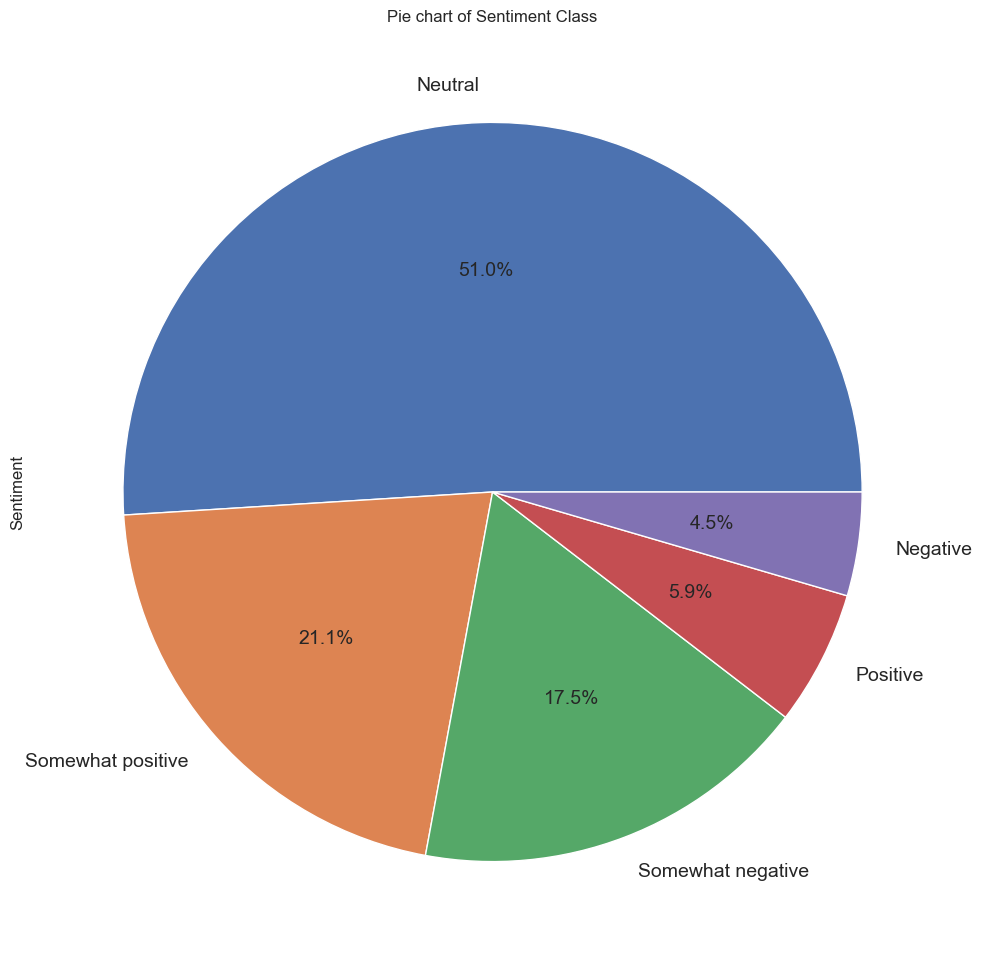

In [10]:
df2=df.copy(deep=True)
pie1=pd.DataFrame(df2['Sentiment'].replace(0,'Negative').replace(1,'Somewhat negative').replace(2,'Neutral').replace(3,'Somewhat positive').replace(4,'Positive').value_counts())
pie1.reset_index(inplace=True)
pie1.plot(kind='pie', title='Pie chart of Sentiment Class',y = 'Sentiment', 
          autopct='%1.1f%%', shadow=False, labels=pie1['index'], legend = False, fontsize=14, figsize=(12,12))

Text(0.5, 0.98, 'Histogram number of words in reviews')

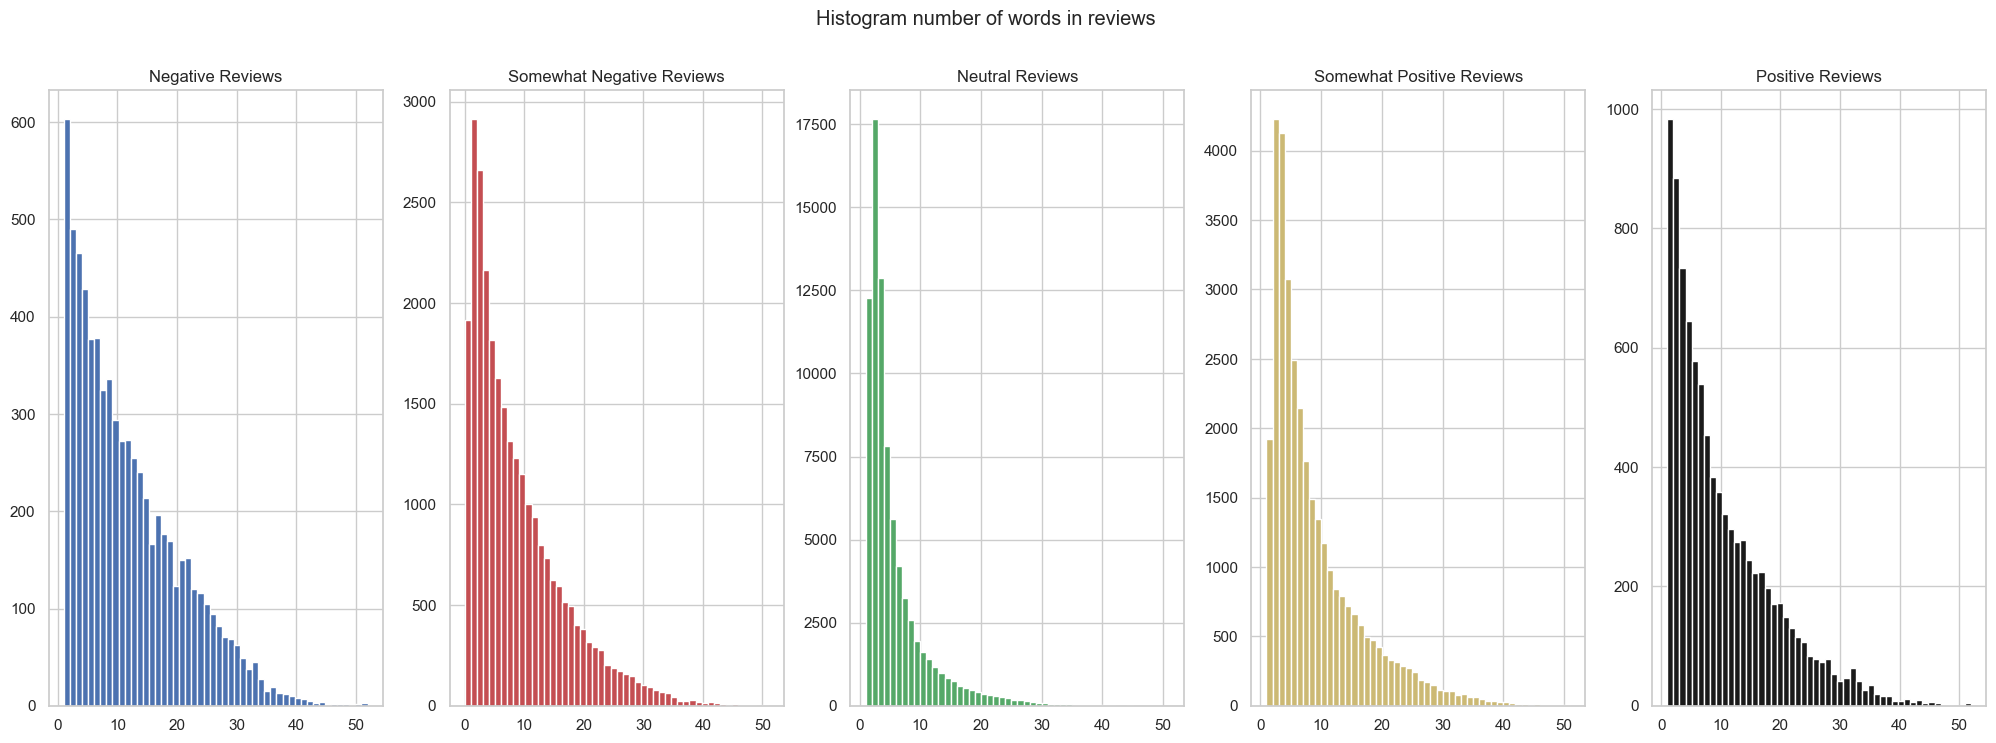

In [11]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5,figsize=(25,8))

ax1.hist(df[df['Sentiment'] == 0]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='b')
ax1.set_title('Negative Reviews')

ax2.hist(df[df['Sentiment'] == 1]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='r')
ax2.set_title('Somewhat Negative Reviews')

ax3.hist(df[df['Sentiment'] == 2]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='g')
ax3.set_title('Neutral Reviews')

ax4.hist(df[df['Sentiment'] == 3]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='y')
ax4.set_title('Somewhat Positive Reviews')

ax5.hist(df[df['Sentiment'] == 4]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='k')
ax5.set_title('Positive Reviews')

f.suptitle('Histogram number of words in reviews')

In [12]:
df['Phrase'].str.split().map(lambda x: len(x)).max()

52

In [13]:
dfff=pd.DataFrame(df['Phrase'].str.split().map(lambda x: len(x))>=20)
print('Number of sentences which contain more than 20 words: ', dfff.loc[dfff['Phrase']==True].shape[0])
print(' ')
dfff=pd.DataFrame(df['Phrase'].str.split().map(lambda x: len(x))>=30)
print('Number of sentences which contain more than 30 words: ', dfff.loc[dfff['Phrase']==True].shape[0])
print(' ')
dfff=pd.DataFrame(df['Phrase'].str.split().map(lambda x: len(x))>=40)
print('Number of sentences which contain more than 40 words: ', dfff.loc[dfff['Phrase']==True].shape[0])
print(' ')
dfff=pd.DataFrame(df['Phrase'].str.split().map(lambda x: len(x))>=50)
print('Number of sentences which contain more than 50 words: ', dfff.loc[dfff['Phrase']==True].shape[0])
print(' ')
dfff=pd.DataFrame(df['Phrase'].str.split().map(lambda x: len(x))==52)
print('Number of sentences which contain 52 words: ', dfff.loc[dfff['Phrase']==True].shape[0])
print(' ')
#dfff.loc[dfff['Phrase']==True]

Number of sentences which contain more than 20 words:  11494
 
Number of sentences which contain more than 30 words:  2568
 
Number of sentences which contain more than 40 words:  352
 
Number of sentences which contain more than 50 words:  18
 
Number of sentences which contain 52 words:  3
 


In [14]:
print(df.loc[87835,'Phrase'])

There are n't too many films that can be as simultaneously funny , offbeat and heartwarming -LRB- without a thick shmear of the goo , at least -RRB- , but `` Elling '' manages to do all three quite well , making it one of the year 's most enjoyable releases .


In [15]:
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

import pandas as pd
from sklearn.model_selection import train_test_split

In [16]:
data = df[['Phrase', 'Sentiment']]

#Set your model output as categorical and save in new label col
data['Sentiment_label']= pd.Categorical(data['Sentiment'])

#Transform your output to numeric
data['Sentiment'] = data['Sentiment_label'].cat.codes

In [17]:
data.head()

,Phrase,Sentiment,Sentiment_label
0,A series of escapades demonstrating the adage ...,1,1
1,A series of escapades demonstrating the adage ...,2,2
2,A series,2,2
3,A,2,2
4,series,2,2


In [18]:
#File contains 150 thousand instances (big)
#consider only test_size=0.1
data_train, data_val = train_test_split(data, test_size=0.1)

In [19]:
#BERT
#Import model, config and tokenizer
from transformers import TFBertModel,  BertConfig, BertTokenizerFast

In [20]:
#model chosed is bert_base_uncased
#max_len is 45(there is only a very small number of large sequences)

model_name = 'bert-base-uncased'

max_length = 45

#Load transformers config and se output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

#Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

#Load the Transformers BERT model
transformer_bert_model = TFBertModel.from_pretrained(model_name, config = config)

2022-12-01 17:29:07.430090: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoi

In [21]:
### ------- Build the model ------- ###

# Load the MainLayer
bert = transformer_bert_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)

# Then build your model output
Sentiments = Dense(units=len(data_train.Sentiment_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='Sentiment')(pooled_output)
outputs = {'Sentiment': Sentiments}

# And combine it all in a model object
model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiClass')

# Take a look at the model
model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the ver

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "BERT_MultiClass"
__________________________________________________________

In [22]:
### ------- Train the model ------- ###

# Set an optimizer
#Learning_rate needs to be: 5e-05
optimizer = Adam(learning_rate=0.1,epsilon=1e-08,clipnorm=1.0)

# Set loss and metrics
loss = {'Sentiment': CategoricalCrossentropy(from_logits = True)}

# Compile the model
model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

# Ready output data for the model
y_train = to_categorical(data_train['Sentiment'])

# Tokenize the input (takes some time)
x_train = tokenizer(
          text=data_train['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

y_val = to_categorical(data_val['Sentiment'])

x_val = tokenizer(
          text=data_val['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

# Fit the model
history = model.fit(
    x={'input_ids': x_train['input_ids']},
    y={'Sentiment': y_train},
    validation_data=({'input_ids': x_val['input_ids']},{'Sentiment': y_val}),
    batch_size=64,
    epochs=1, #Needs to be 2
    verbose=1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2195/2195 [==============================] - ETA: 0s - loss: 17.6836 - accuracy: 0.2934WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fc4ac05d5f0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach

In [25]:
#Evaluate on validation set:
#We will compute the error metrics on the validation set in order to have an 
#idea of the model performance.
model_eval = model.evaluate(
    x={'input_ids': x_val['input_ids']},
    y={'Sentiment': y_val})

488/488 [==============================] - 600s 1s/step - loss: 32.8339 - accuracy: 0.5117


In [26]:
y_val_predicted = model.predict(
    x={'input_ids': x_val['input_ids']},)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
488/488 [==============================] - 605s 1s/step


In [27]:
y_val_predicted['Sentiment']

array([[ 66.44549, 113.04249, 141.24277,  71.96334, -20.05813],
       [ 66.44549, 113.04249, 141.24277,  71.96334, -20.05813],
       [ 66.44549, 113.04249, 141.24277,  71.96334, -20.05813],
       ...,
       [ 66.44549, 113.04249, 141.24277,  71.96334, -20.05813],
       [ 66.44549, 113.04249, 141.24277,  71.96334, -20.05813],
       [ 66.44549, 113.04249, 141.24277,  71.96334, -20.05813]],
      dtype=float32)

In [28]:
y_val

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [32]:
y_val_pred_max=[np.argmax(i) for i in y_val_predicted['Sentiment']]

In [33]:
y_val_actual_max=[np.argmax(i) for i in y_val]

In [34]:
from sklearn.metrics import classification_report

report = classification_report(y_val_pred_max, y_val_actual_max)

print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      0.51      0.68     15606
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.51     15606
   macro avg       0.20      0.10      0.14     15606
weighted avg       1.00      0.51      0.68     15606



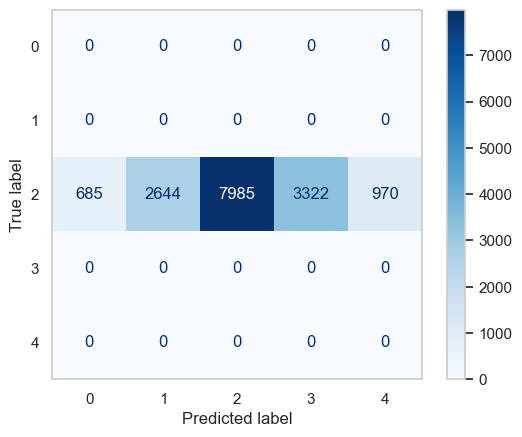

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val_pred_max, y_val_actual_max), display_labels=np.unique(y_val_actual_max))
disp.plot(cmap='Blues') 
plt.grid(False)

In [38]:
#RoBERTa
from transformers import RobertaTokenizer, TFRobertaModel, RobertaConfig  

In [ ]:
### --------- Setup Roberta ---------- ###

model_name = 'roberta-base'

# Max length of tokens
max_length = 40

# Load transformers config and set output_hidden_states to False
config = RobertaConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load Roberta tokenizer
tokenizer = RobertaTokenizer.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Roberta model
transformer_roberta_model = TFRobertaModel.from_pretrained(model_name, config = config)

In [ ]:
### ------- Build the model ------- ###

# Load the MainLayer
roberta = transformer_roberta_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers RoBERTa model as a layer in a Keras model
roberta_model = roberta(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(roberta_model, training=False)

# Then build your model output
Sentiments = Dense(units=len(data_train.Sentiment_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='Sentiment')(pooled_output)
outputs = {'Sentiment': Sentiments}

# And combine it all in a model object
model2 = Model(inputs=inputs, outputs=outputs, name='RoBERTa_MultiClass')

# Take a look at the model
model2.summary()

In [ ]:
### ------- Train the model ------- ###

# Set an optimizer
optimizer = Adam(learning_rate=5e-05,epsilon=1e-08,decay=0.01,clipnorm=1.0)

# Set loss and metrics
loss = {'Sentiment': CategoricalCrossentropy(from_logits = True)}

# Compile the model
model2.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

# Ready output data for the model
y_train = to_categorical(data_train['Sentiment'])

# Tokenize the input (takes some time)
x_train = tokenizer(
          text=data_train['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

y_val = to_categorical(data_val['Sentiment'])

x_val = tokenizer(
          text=data_val['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

# Fit the model
history = model2.fit(
    x={'input_ids': x_train['input_ids']},
    y={'Sentiment': y_train},
    validation_data=({'input_ids': x_val['input_ids']},{'Sentiment': y_val}),
    batch_size=64,
    epochs=2,
    verbose=1)

In [39]:
#Evaluate on validation set:
model_eval = model2.evaluate(
    x={'input_ids': x_val['input_ids']},
    y={'Sentiment': y_val})

NameError: name 'model2' is not defined

In [ ]:
y_val_predicted = model2.predict(
    x={'input_ids': x_val['input_ids']},)

In [ ]:
y_val_predicted['Sentiment']

In [ ]:
y_val

In [ ]:
y_val_pred_max=[np.argmax(i) for i in y_val_predicted['Sentiment']]

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_val_pred_max, y_val_actual_max)

print(report)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val_pred_max, y_val_actual_max), display_labels=np.unique(y_val_actual_max))
disp.plot(cmap='Blues') 
plt.grid(False)

In [ ]:
#DistilBERT